# Strings are savage

Strings may include anything.  Previously, we modified the behavior strings using input transformers.  In retrospect, this approach may have been excessive.  Let's try creating custom string formatters based on specific conditions.

In [1]:
ip=get_ipython()

In [2]:
from graphviz import Source

In [3]:
from IPython.display import display

In [4]:
from IPython.utils.capture import capture_output as capture

In [9]:
from IPython.display import *

In [28]:
from toolz.curried import *

In [29]:
from mimetypes import guess_type; guess = compose(first, guess_type)

In [51]:
def macros(str, **data):
    data['text/plain'] = str
    if str.startswith('digraph ') or str.startswith('graph '):
        data[guess(' .svg')] = Source(str)._repr_svg_()
    if str.startswith('http') and len(str.splitlines()) == 1:
        data[guess(' .html')] = IFrame(str, width="100%", height=400)._repr_html_()
    return data, {}

get_ipython().display_formatter.mimebundle_formatter.for_type(str, macros)

<function __main__.macros(str, **data)>

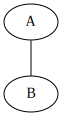

In [52]:
"""graph {A--B}"""

In [53]:
"https://en.wikipedia.org/wiki/Literate_programming"

'https://en.wikipedia.org/wiki/Literate_programming'

This approach takes significantly less code.